# Guided Activity Three
## Orbital Motion

Round three with Python! 

We will be building a model of orbital motion, this time applying the Euler method in more than one spatial dimension. In the spirit of good code re-use, I will try to modify my Euler method from GA2 to accept multi-dimensional x and v parameters.

As usual, we start with imports.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

We are working in multiple dimension, so the magnitude of a vector is more complex than just the x-coordinate. We want the euclidean distance between points, and a convenient way to get this is the linear algebra concept of a `norm`. Nifty one-liner, huh?

In [2]:
def dist(x):
    ''' Return the distance of point x from the origin <0, 0, .., 0>.
    
        Uses the linear algebra concept of a norm to calculate 
        Euclidean distance.
        
        Examples:
            Given two vectors A = <0,3,8> and B = <0,3,9>
                >>> A = np.asarray([0,3,8])
                >>> B = np.asarray([0,3,9])
        
            Find the length of A.
                >>> dist(A)

            Find the distance between A and B.
                >>> dist(A - B)
                
            Given a list of vectors C = [<1,1,1>, <2,3,5>, <8,3,7>].
                >>> C = np.asarray([[1,1,1], [2,3,5], [8,3,7]])
                
            Find the distances from the origin, O.
                >>> dist(C)
                
            Find the distances from point B.
                >>> dist(C - B)
            
        Args:
            x (np.array):   point or list of points.
            
        Returns:
            np.array: scalar distance or list of scalar distances.
    '''
    
    return np.linalg.norm(x, axis=(x.ndim - 1))

Then we can built a generic gravitational acceleration function. This is slightly different than GA1 and GA2 because it both accepts and returns multi-dimensional inputs and outputs. Heck, we could play with orbital motion in 4-spacial dimensions with this function!

In [3]:
def gravitational_acceleration(x, v, m, M=5.972e24, G=6.67408e-11):
    ''' Return x and y components of acceleration due to gravitity.
    
        Uses:
                    G * m * M / r**2
                    
        Args:
            G (float):   gravitational constant (m**3/(kg * s**2)))
            M (float):   mass of larger object (kg; default is Earth)
            m (float):   mass of smaller object (kg)
            x (float):   x distance from larger object (m)
            y (float):   y distance from larger object (m)
        
        Return:
            [float, float]: direction vector
    '''
    
    r = dist(x)
    a = -(x * G * M) / (np.power(r, 3))
    
    return a

This activity compares the Euler and Euler-Cromer methods, so we will probably need a way to calculate energy.

$$
    E = U_g + U_k
$$

Where:
    
$$
    U_k = \frac{1}{2} m v^2
$$

and,

$$ 
    U_g = -\frac{G m M}{r}
$$

In [4]:
def orbital_energy(x, v, m, y=[0,0], M=5.972e24, G=6.67408e-11):
    ''' Return energy of orbital body in joules. 
    
        Uses:
        
                E = Ug + Uk
            
                where,
                
                    Ug = -GmM / r
                    
                    Uk = 0.5 mv^2
                    
        Args:
            x (float):   x distance from larger object (m)
            v (float):   velcoity of orbiting body (m/s)
            G (float):   gravitational constant (m**3/(kg * s**2)))
            M (float):   mass of larger object (kg; default is Earth)
            m (float):   mass of smaller object (kg)
            y (float):   location of larger object (m; default is (0,0))
        
        Return:
            (float): energy of orbit in joules.
    '''
    
    r = dist(x - y)
    v_avg = dist(v)
    
    return (0.5* m * v_avg * v_avg) - (G * m * M / r)

Now let's reuse the Euler method from our last excercise, being careful to make sure it will accept array inputs. I want to rewrite some of it in super fast (yet horribly unreadable, ugly) numpy arrays.

In [5]:
def euler_method(acceleration, t0, tf, dt, x0=0, v0=0, modified=False, **kwargs):
    ''' Returns t, x, v, and a arrays for Euler Method

        Args:
            acceleration (func):  a function that accepts x, v, and **kwargs and 
                                      return acceleration.
            t0 (float):           initial time (s)
            tf (float):           final time (s)
            dt (float):           time step (s)
            x0 (np.array):        initial displacement, downwards positive (m)
            v0 (np.array):        intiial velocity, downwards positive (m/s)
            **kwargs:             any additional arguments required for the 
                                      accleration function

            modified (bool):	turns on modified euler method.

        Returns:
            np.float64 (np.array): lisf times (s)
            np.float64 (np.array): list of positions, downwards positive (m)
            np.float64 (np.array): list of velocities, downwards positive (m/s)
            np.float64 (np.array): list of acceleration, downwards positive (m/s**2)
    '''

    t = np.arange(start=t0, stop=tf, step=dt, dtype=np.float64)
    
    points = t.size
    dimensions, = x0.shape
    
    x = np.empty([points, dimensions])
    v = np.empty([points, dimensions])
    a = np.empty([points, dimensions])
    
    x[0] = x0
    v[0] = v0
    a[0] = acceleration(x0, v0, **kwargs)

    for i in range(1, points):
        a[i] = acceleration(x[i-1], v[i-1], **kwargs)
        
        if modified:
            v[i] = v[i-1] + dt * a[i]
            x[i] = x[i-1] + dt * v[i]
        else:        
            x[i] = x[i-1] + dt * v[i-1]
            v[i] = v[i-1] + dt * a[i]
        
    return t, x, v, a

Now our astronomical functions for closestest and further points of orbit.

In [30]:
def periapsis(xs, y=0):
    ''' Returns nearest point of object (xs) to center (y).
    
        Args:
            xs (np.array):    list of positions (n-dimensions)
             y (np.array):    single position (n-dimensions)
             
        Returns:
            np.array:  n-dimensional np.float64
    '''
    
    return dist(xs - y).min()

In [31]:
def apoapsis(xs, y=0):
    ''' Returns furthest point of object (xs) from center (y).
    
        Args:
            xs (np.array):    list of positions (n-dimensions)
             y (np.array):    single position (n-dimensions)
             
        Returns:
            np.array:  n-dimensional np.float64
    '''
        
    return dist(xs - y).max()

The oribital period calculation is a little more complex. If we plot the x-position (or y-) against time, the orbit produces a sinusoid plot. We can use our period finding code from the last guided activity to find the orbital period, so long as we complete at least a few cycles. 

In [8]:
def orbital_period(t, x):
    ''' Return period of signal, specifically an orbital period. 
    
        Performs a FFT and returns the frequency of the strongest frequency
        in the sample.
        
        NOTE: Due to the nature of an FFT, more orbits lead to more resolution.
        
        Args:
            t (list):  times (s)
            x (list):  response (unitless)
            
        Returns:
            float:  strongest frequency (Hz)
    
    '''
    from scipy import fftpack

    # Find the sample rate
    dt = t[1] - t[0]
    
    # Perform FFT
    amplitudes  = fftpack.fft(x)
    frequencies = fftpack.fftfreq(len(x)) / dt

    # Return the period with maximum amplitude.
    return 1 / np.abs(frequencies[amplitudes.argmax()])

Now that we have all our convinience functions in place, we can try plotting an orbit.

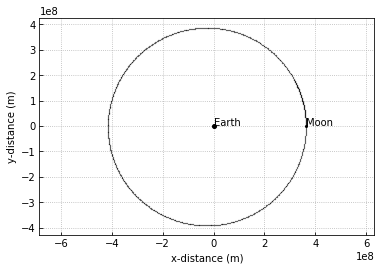

In [9]:
# Initial conditions (see https://nssdc.gsfc.nasa.gov/planetary/factsheet/moonfact.html)
x0 = np.asarray([0.3633e9, 0], dtype=np.float64) # m 
v0 = np.asarray([0,  1.082e3], dtype=np.float64) # m/s
m = 7.34767309e22 # kg

# Simulation parameters.
dt   = 1 # Hours
time = 30 # Days

# Run simulation.
t, x, v, a = euler_method(gravitational_acceleration,
                            x0=x0,
                            v0=v0,
                            t0=np.asarray(0.0, dtype=np.float64),
                            tf=np.asarray(3600*24*time, dtype=np.float64),
                            dt=np.asarray(3600*dt, dtype=np.float64),
                            modified=True,
                            m=m)

# Plot orbit and label bodies.
plt.plot(x[:,0], x[:,1], color='black', marker='o', markersize=0.25, linestyle='')
plt.plot(0, 0, marker='o', color='black', markersize=4)
plt.plot(x0[0], x0[1], marker='o', color='black', markersize=2)
plt.annotate('Earth', (0,0))
plt.annotate('Moon', x0)

# Adjust plot parameters and labels.
plt.tick_params(which='both', direction='in')
plt.grid(which='both', linestyle=':')
plt.axis('equal')
plt.xlabel('x-distance (m)')
plt.ylabel('y-distance (m)')
plt.show()

Not bad, at least it looks like a circle.

### Excercise 1

Recall that in class when we built the gravitational model fo the moon orbiting the Earth with a spreadsheet, we employed the modified Euler method (also known as the Euler-Cromer method) to complete the model. To gain an appreciation of why it is important to use this modified algorithm, first build a compuational (MATLAB or C) model of the moon's orbit arund Earth using the simple, non-modified Euler method. What happens to the moon's trajectory in your model (Hint: somethind disatrous!)? Provide plost of the moon's trajectory to demonstrate this disastrous behavior. Can you get reid fo the artifical behavior by making $\Delta t$ smaller? Next, build the model (MATLAB or C) using the Euler-Cromer method. Demonstrate your model porduces the correct period of orbit. Finally, try (*thanks for the confidence Roos*) to make an intelligent comment about why the Euler-Cromer algorithm works, and the non-modified Euler algorithm does not. Is there soemthing you can calculated and plot that may provide insite into why the Euler algorithm fails?

#### Solution 1

##### ( Step 1 ) Plot the Moon's Trajectory using Euler and Euler-Cromer

I'll start by ploting the trajectory of the Moon orbiting around the Earth using both the Euler and Euler-Cromer methods. For an apples-to-apples comparison, I will use a time-step of 1 hour. 

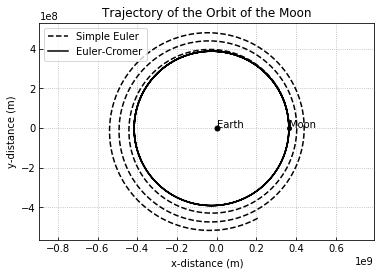

In [10]:
# Initial conditions (see https://nssdc.gsfc.nasa.gov/planetary/factsheet/moonfact.html)
x0 = np.asarray([0.3633e9, 0], dtype=np.float64) # m 
v0 = np.asarray([0,  1.082e3], dtype=np.float64) # m/s
m = 7.34767309e22 # kg

# Simulation parameters.
dt   = 1 # Hours
time = 100# Days

# Run simulation.
t_smp, x_smp, v_smp, a_smp = euler_method(gravitational_acceleration,
                                          x0=x0,
                                          v0=v0,
                                          t0=np.asarray(0.0, dtype=np.float64),
                                          tf=np.asarray(3600*24*time, dtype=np.float64),
                                          dt=np.asarray(3600*dt, dtype=np.float64),
                                          modified=False,
                                          m=m)

t_cro, x_cro, v_cro, a_cro = euler_method(gravitational_acceleration,
                                          x0=x0,
                                          v0=v0,
                                          t0=np.asarray(0.0, dtype=np.float64),
                                          tf=np.asarray(3600*24*time, dtype=np.float64),
                                          dt=np.asarray(3600*dt, dtype=np.float64),
                                          modified=True,
                                          m=m)

# Plot orbit and label bodies.
plt.plot(0, 0, marker='o', color='black', markersize=5)
plt.plot(x0[0], x0[1], marker='o', color='black', markersize=4)
plt.annotate('Earth', (0,0))
plt.annotate('Moon', x0)

# Plot both Simple Euler and Euler-Cromer solutionns.
plt.plot(x_smp[:,0], x_smp[:,1], color='black', linestyle='--', label='Simple Euler')
plt.plot(x_cro[:,0], x_cro[:,1], color='black', linestyle='-', label='Euler-Cromer')

# Adjust plot parameters and labels.
plt.tick_params(which='both', direction='in')
plt.grid(which='both', linestyle=':')
plt.axis('equal')
plt.xlabel('x-distance (m)')
plt.ylabel('y-distance (m)')
plt.title('Trajectory of the Orbit of the Moon')
plt.legend(loc='upper left')
plt.show()

**( Step 2 ) Does decreasing dt fix the problem?**

Clearly, according to the simple Euler method, the Moon is moving away from the Earth significantly with each orbit. While the Moon *is* slowly moving away from the earth, its not thousands of meters a month as our simulation would lead us to believe. Lets show the Euler method for a few different time-steps.

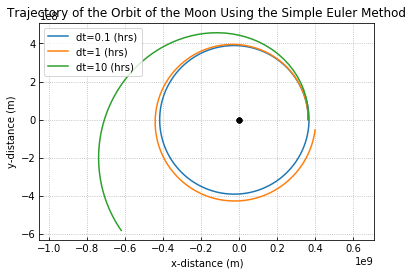

In [11]:
for dt in [0.1, 1, 10]: # dt in hours
    # Simulation parameters.
    time = 30 # Days

    # Run simulation.
    t_smp, x_smp, v_smp, a_smp = euler_method(gravitational_acceleration,
                                              x0=x0,
                                              v0=v0,
                                              t0=np.asarray(0.0, dtype=np.float64),
                                              tf=np.asarray(3600*24*time, dtype=np.float64),
                                              dt=np.asarray(3600*dt, dtype=np.float64),
                                              modified=False,
                                              m=m)

    # Plot orbit and label bodies.
    plt.plot(0, 0, marker='o', color='black', markersize=5)
    plt.plot(x_smp[:,0], x_smp[:,1], label='dt={} (hrs)'.format(dt))

# Adjust plot parameters and labels.
plt.tick_params(which='both', direction='in')
plt.grid(which='both', linestyle=':')
plt.axis('equal')
plt.xlabel('x-distance (m)')
plt.ylabel('y-distance (m)')
plt.title('Trajectory of the Orbit of the Moon Using the Simple Euler Method')
plt.legend(loc='upper left')
plt.show()

Clearly the trajectory become more realistic as the time-step becomes smaller; however, all the simulations using Euler-Cromer as still divegent given enough time. While studying simple harmonic oscillators in the last guided activity, we found that the Euler-Cromer conserved energy over the long term whereas the Simple Euler method did not. Is that still the case? We will use a small time-step to be sure.

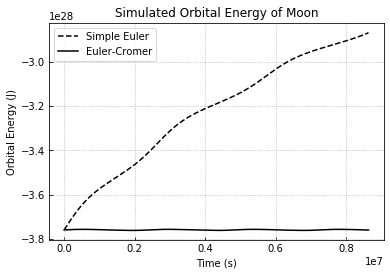

In [12]:
# Simulation parameters.
dt   = 1 # Hours
time = 100 # Days

# Run simulation.
t_smp, x_smp, v_smp, a_smp = euler_method(gravitational_acceleration,
                                          x0=x0,
                                          v0=v0,
                                          t0=np.asarray(0.0, dtype=np.float64),
                                          tf=np.asarray(3600*24*time, dtype=np.float64),
                                          dt=np.asarray(3600*dt, dtype=np.float64),
                                          modified=False,
                                          m=m)

t_cro, x_cro, v_cro, a_cro = euler_method(gravitational_acceleration,
                                          x0=x0,
                                          v0=v0,
                                          t0=np.asarray(0.0, dtype=np.float64),
                                          tf=np.asarray(3600*24*time, dtype=np.float64),
                                          dt=np.asarray(3600*dt, dtype=np.float64),
                                          modified=True,
                                          m=m)


# Plot both Simple Euler and Euler-Cromer solutionns.
plt.plot(t_smp, orbital_energy(x_smp, v_smp, m), color='black', linestyle='--', label='Simple Euler')
plt.plot(t_cro, orbital_energy(x_cro, v_cro, m), color='black', linestyle='-', label='Euler-Cromer')

# Adjust plot parameters and labels.
plt.tick_params(which='both', direction='in')
plt.grid(which='both', linestyle=':')
plt.xlabel('Time (s)')
plt.ylabel('Orbital Energy (J)')
plt.title('Simulated Orbital Energy of Moon')
plt.legend(loc='upper left')
plt.show()

Clearly something is wrong with the Euler-Cromer method, because the system is gaining energy with time!

Let's consider the mathematics of this for a momement. In oscillatory systems (i.e. simple harmonic oscillators, planetary orbits), the simple Euler method fails to conserve energy and makes for a particularly bad approximation. Both the Simple Euler and the Euler-Cromer method of first-order integral approximation--so the error between timesteps is proportional to the size of the error; however, in the simple Euler, the error accumulates in a single direction with time, whereas with the Euler-Cromer, with each oscillation the error destructively iterferes. A deeper explanation apparently requires an understanding of "Hamiltonian Equations". 

### Exercise 2

Alter your (MATLAB or C) program to model the orbital trajectory of Halley's Commet around the Sun. Produce plots of the orbital trajectory and demonstrate that your model correctly simulated the period, the aphelion, and perihelion of the comet's orbit. Don't forget to address the accuracy issue (what is a sufficiently small $\Delta t$?

#### Solution 2

Clearly the hardest part of this portion has been locating relaiable values for x0 and v0! The astronomical coordinate system has a long, convoluted etymology that would probably make more sense to someone who does atronomy for a living. 

Here is the best I have:

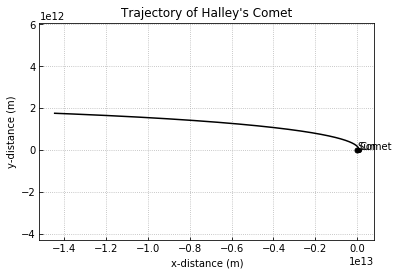

In [17]:
# adsabs.harard.edu/abs
# 1P/Halley Distance @ Perihelion: 8.766e10 m
# 1P/Halley Velocity @ Perihelion: 55000 m/s

# https://nssdc.gsfc.nasa.gov/planetary/factsheet/sunfact.html
# Sun Mass: 1988500e24 kg

# Initial conditions (see https://nssdc.gsfc.nasa.gov/planetary/factsheet/moonfact.html)
x0 = np.asarray([8.766e10, 0], dtype=np.float64) # m 
v0 = np.asarray([0,  55000], dtype=np.float64) # m/s
M = 1988500e24 # kg

# Simulation parameters.
dt   = 24 # Hours
time = 75 # Years

# Run simulation.
t, x, v, a = euler_method(gravitational_acceleration,
                            x0=x0,
                            v0=v0,
                            t0=np.asarray(0.0, dtype=np.float64),
                            tf=np.asarray(3600*24*365.25*time, dtype=np.float64),
                            dt=np.asarray(3600*dt, dtype=np.float64),
                            modified=True,
                            m=10,
                            M=M)


# Plot orbit and label bodies.
plt.plot(0, 0, marker='o', color='black', markersize=5)
plt.plot(x0[0], x0[1], marker='o', color='black', markersize=4)
plt.annotate('Sun', (0,0))
plt.annotate('Comet', x0)

# Plot both Simple Euler and Euler-Cromer solutionns.
plt.plot(x[:,0], x[:,1], color='black', linestyle='-')

# Adjust plot parameters and labels.
plt.tick_params(which='both', direction='in')
plt.grid(which='both', linestyle=':')
plt.axis('equal')
plt.xlabel('x-distance (m)')
plt.ylabel('y-distance (m)')
plt.title('Trajectory of Halley\'s Comet')
plt.show()

While I can get an answer, I do not trust the model. Halley's Comet orbits at a veclocity near its escape velocity. This means that very small changes in the velocity of the orbit lead to massive changes in orbital distance and period. Further, the numbers coming from NASA do not seem to be precise enough. If I use the exact values from NASA's site, the metor escapes, and the orbital period is infinite! 

Because I know the oribtal period is approximately 75 years, I adjusted (fudged) v0, to get the correct period.

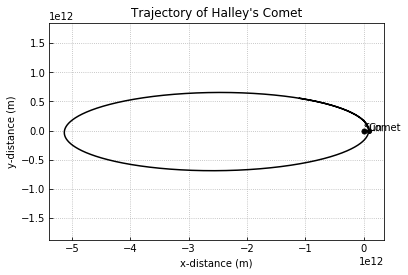

In [25]:
# adsabs.harard.edu/abs
# 1P/Halley Distance @ Perihelion: 8.766e10 m
# 1P/Halley Velocity @ Perihelion: 55000 m/s -> 54562 m/s (my number)

# https://nssdc.gsfc.nasa.gov/planetary/factsheet/sunfact.html
# Sun Mass: 1988500e24 kg

# Initial conditions (see https://nssdc.gsfc.nasa.gov/planetary/factsheet/moonfact.html)
x0 = np.asarray([8.766e10, 0], dtype=np.float64) # m 
v0 = np.asarray([0,  54562], dtype=np.float64) # m/s
M = 1988500e24 # kg

# Simulation parameters.
dt   = 6 # Hours
time = 75 # Years

# Run simulation.
t, x, v, a = euler_method(gravitational_acceleration,
                            x0=x0,
                            v0=v0,
                            t0=np.asarray(0.0, dtype=np.float64),
                            tf=np.asarray(3600*24*365.25*time, dtype=np.float64),
                            dt=np.asarray(3600*dt, dtype=np.float64),
                            modified=True,
                            m=10,
                            M=M)


# Plot orbit and label bodies.
plt.plot(0, 0, marker='o', color='black', markersize=5)
plt.plot(x0[0], x0[1], marker='o', color='black', markersize=4)
plt.annotate('Sun', (0,0))
plt.annotate('Comet', x0)

# Plot both Simple Euler and Euler-Cromer solutionns.
plt.plot(x[:,0], x[:,1], color='black', linestyle='-')

# Adjust plot parameters and labels.
plt.tick_params(which='both', direction='in')
plt.grid(which='both', linestyle=':')
plt.axis('equal')
plt.xlabel('x-distance (m)')
plt.ylabel('y-distance (m)')
plt.title('Trajectory of Halley\'s Comet')
plt.show()

Lets run the simulation for a few orbits to provide enough data for our FFT.

In [47]:
x0 = np.asarray([8.766e10, 0], dtype=np.float64) # m 
v0 = np.asarray([0,  54562], dtype=np.float64) # m/s
M = 1988500e24 # kg

# Simulation parameters.
dt   = 24 # Hours
time = 300 # Years

# Run simulation.
t, x, v, a = euler_method(gravitational_acceleration,
                            x0=x0,
                            v0=v0,
                            t0=np.asarray(0.0, dtype=np.float64),
                            tf=np.asarray(3600*24*365.25*time, dtype=np.float64),
                            dt=np.asarray(3600*dt, dtype=np.float64),
                            modified=True,
                            m=10,
                            M=M)

In [49]:
print('The orbital period was approximately {:.2f} years.'.format(orbital_period(t, x[:,1]) / 60 / 60 / 24 / 365.25))
print('The comet has an apoapsis of {:.0f} m and a periapsis of {:.0f} m'.format(apoapsis(x), periapsis(x)))

The orbital period was approximately 75.00 years.
The comet has an apoapsis of 5240625897997 m and a periapsis of 87643443310 m


The real values are (adsabs.harard.edu/abs):
     
     1P/Halley Distance @ Perihelion: 8.766e10 m (8.764e10; 0.02 % Error)
     
     1P/Helley Distance @ Aphelion:   5.3e12     (5.2e12;   1.90 % Error)

I did not bother to determine what size dt was required. I started with 24 hours, the graph looked close enough to an orbit, and **from the earlier simulation I know my error is dominated by the lack of precision in my v0**. Considering the accuracy of the aphelion prediction, I would argue that a max orbital velocity of 54562 m/s is probably more accurate than the number NASA provided (55000 m/s).